<a href="https://colab.research.google.com/github/Atharva-Gaykar/Exam/blob/main/Vision_Transformer_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Vision Transformer (ViT) — Built from Scratch in PyTorch

This project implements a complete **Vision Transformer (ViT)** architecture from scratch using PyTorch — without relying on any high-level libraries like `timm` or `transformers`.

---

## 🧱 Components You’ve Built:

### 1. 🧩 Patch Embedding ✅
- Splits the input image into **non-overlapping patches**
- Uses a **Conv2d layer** with:
  - `kernel_size = patch_size`
  - `stride = patch_size`
- Projects each patch to a fixed-size vector (`embed_dim`)
- Output shape: **(B, num_patches, embed_dim)**

---

### 2. 🏷️ `[CLS]` Token & Positional Embeddings ✅
- A **learnable `[CLS]` token** is prepended to each image sequence
- Learnable **positional embeddings** are added to retain patch order
- `[CLS]` token shape before expand: `(1, 1, embed_dim)`
- After `.expand(B, -1, -1)`: shape becomes `(B, 1, embed_dim)`
- Final input to Transformer: **(B, num_patches + 1, embed_dim)**

---

### 3. 🧠 Transformer Encoder Block ✅
- **LayerNorm → Multi-Head Attention → Residual**
- **LayerNorm → MLP (GELU + Linear) → Residual**
- Supports multiple stacked blocks via `nn.Sequential`
- Captures both **local and global** relationships between patches

---

### 4. 🎯 MLP Head ✅
- Uses only the output corresponding to `[CLS]` token (`x[:, 0]`)
- Applies:
  - LayerNorm
  - Final Linear layer → for classification (`num_classes`)

---

## 🔁 Overall Data Flow:

```text
Input Image (B, 3, H, W)
        ↓
PatchEmbedding (Conv2d → flatten → transpose)
        ↓
(B, num_patches, embed_dim)
        ↓
+ [CLS] token + Positional Embeddings
        ↓
(B, num_patches + 1, embed_dim)
        ↓
Transformer Encoder Layers
        ↓
Select CLS token output: x[:, 0]
        ↓
MLP Head
        ↓
Final Output: (B, num_classes)


VISION TRANSFORMER ARCHITECTURE

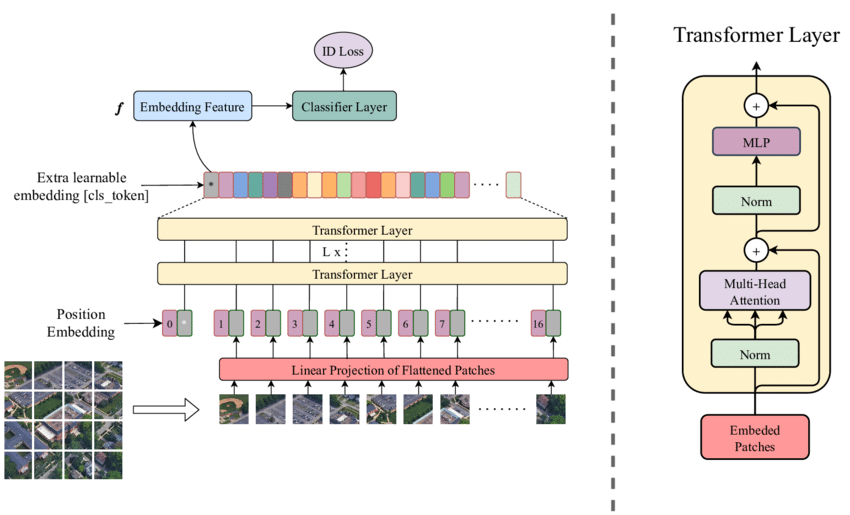

In [ ]:
import torch
import torch.nn as nn


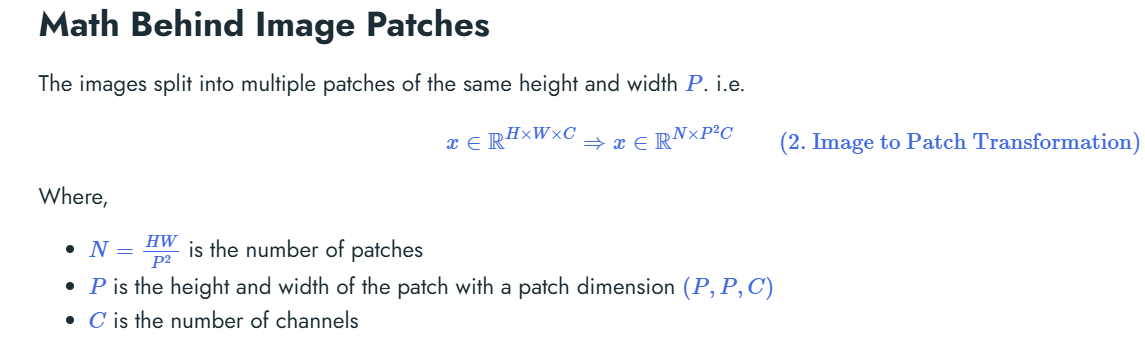

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)        # (B, embed_dim, H', W')
        x = x.flatten(2)        # (B, embed_dim, N)
        x = x.transpose(1, 2)   # (B, N, embed_dim)
        return x

- B is the Batch Size

- N is the number of patches

- embed_dim is embedding dimension





### ✅ Goal of `PatchEmbedding`

This module is responsible for:

- 📦 **Dividing the input image into non-overlapping patches.**
- 🔁 **Flattening each patch and projecting it to a fixed embedding size.**
- 🚀 **Preparing the patch embeddings for the Transformer input.**


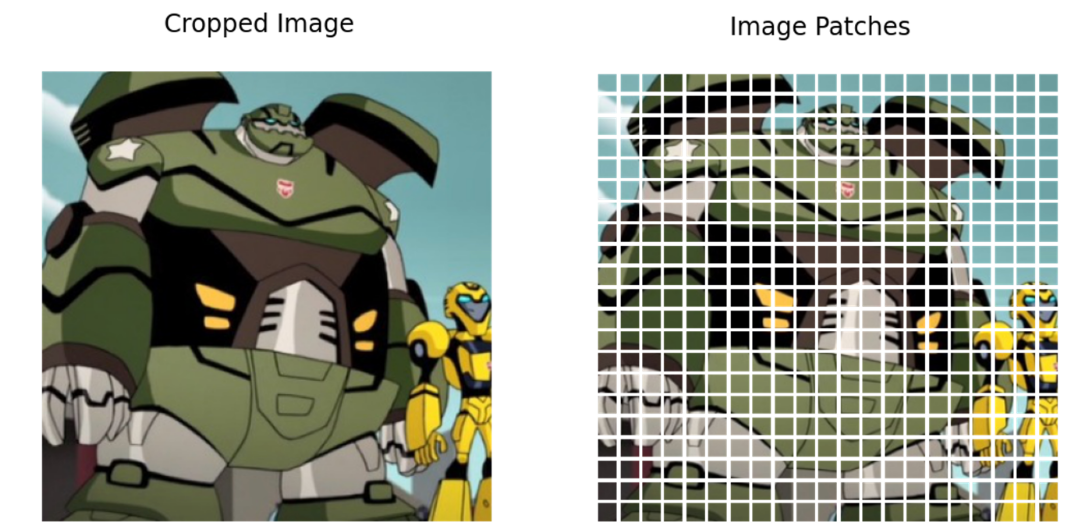

In [ ]:
model_PE = PatchEmbedding(img_size=224, patch_size=16, in_channels=3, embed_dim=768)
dummy_input = torch.randn(8, 3, 224, 224)  # (batch_size, channels, height, width)
out = model_PE(dummy_input)
print(out.shape)  # should be (8, 196, 768)


torch.Size([8, 196, 768])


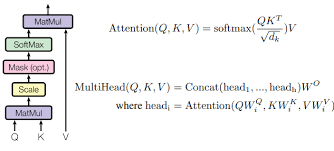

In [ ]:
import torch.nn as nn

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, mlp_dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

    def forward(self, x):
        # Self-attention block
        x_norm1 = self.norm1(x)
        attn_output, _ = self.attn(x_norm1, x_norm1, x_norm1)
        x = x + attn_output  # Residual connection

        # MLP block
        x_norm2 = self.norm2(x)
        mlp_output = self.mlp(x_norm2)
        x = x + mlp_output  # Residual connection

        return x


### 🔄 Transformer Encoder Block: Input Flow

The input to a Transformer encoder block in a Vision Transformer (ViT) goes through the following steps:

1. **Input Shape**:
   - The input `x` has shape **(B, N, D)**, where:
     - **B** = batch size
     - **N** = number of patches (including `[CLS]` token if used)
     - **D** = embedding dimension

2. **Layer Normalization + Multi-Head Self-Attention**:
   - Input `x` is normalized using **LayerNorm**.
   - Then passed to a **Multi-Head Self-Attention (MHSA)** module.
   - MHSA captures contextual relationships between image patches.

3. **Residual Connection (1)**:
   - The attention output is added back to the original input (`x`) to form the first residual connection:
     ```
     x = x + SelfAttention(LayerNorm(x))
     ```

4. **Layer Normalization + MLP (Feedforward)**:
   - The updated `x` is normalized again using a second **LayerNorm**.
   - Then passed through a 2-layer **MLP** with a **GELU** activation in between.

5. **Residual Connection (2)**:
   - The MLP output is added back to the input to this block, forming the second residual connection:
     ```
     x = x + MLP(LayerNorm(x))
     ```

6. **Output Shape**:
   - The output has the **same shape** as the input: **(B, N, D)**.
   - This output is typically fed into the next encoder block (if stacked).

---

### 🧠 Summary

Each Transformer encoder block enhances the patch embeddings by:
- **Capturing global context** via self-attention
- **Applying non-linear transformations** via MLP
- **Preserving stability** with residual connections and layer normalization

This block can be **stacked multiple times** to form a deep Vision Transformer model.


ACTIVATION FUNCTION USED

GELU(x)=x⋅Φ(x)

Where
Φ
(
x
)
 is the standard Gaussian cumulative distribution function (CDF)

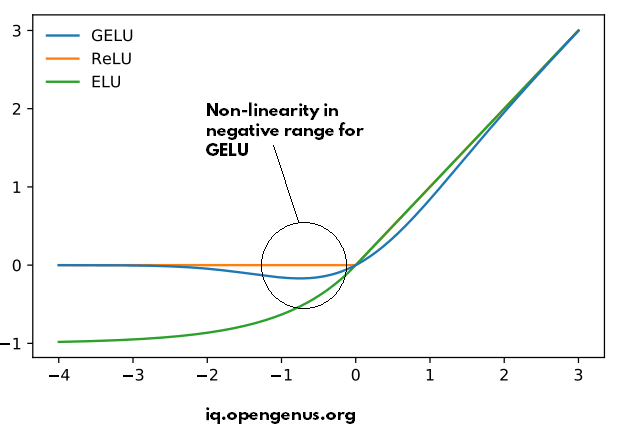

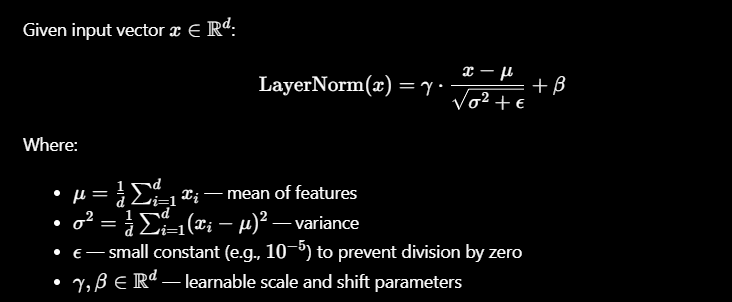

In [ ]:
# test code
encoder_block = TransformerEncoderBlock(embed_dim=768, mlp_dim=3072, num_heads=12)
dummy_input = torch.randn(8, 197, 768)  # (batch_size, num_patches + 1, embed_dim)
out = encoder_block(dummy_input)
print(out.shape)  # should be (8, 197, 768)


torch.Size([8, 197, 768])


In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3,
                 embed_dim=768, mlp_dim=3072, num_heads=12,
                 transformer_units=12, num_classes=10):
        super().__init__()

        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        self.transformer_layers = nn.Sequential(
            *[TransformerEncoderBlock(embed_dim, mlp_dim, num_heads) for _ in range(transformer_units)]
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)  # (B, num_patches, embed_dim)
        B = x.size(0)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)          # (B, num_patches+1, embed_dim)
        x = x + self.pos_embed                         # Add positional embeddings

        x = self.transformer_layers(x)                 # (B, num_patches+1, embed_dim)
        x = x[:, 0]                                     # CLS token output
        x = self.mlp_head(x)                           # (B, num_classes)

        return x



### 🧠 Understanding the `[CLS]` Token in Vision Transformer

- `self.cls_token` has shape **(1, 1, embed_dim)** — a **single learnable token** shared across the model.

- When we do:
  ```python
  cls_tokens = self.cls_token.expand(B, -1, -1)
````

* This **creates a view** of the `[CLS]` token, repeated **B times** (once for each image in the batch), without allocating new memory.

* The resulting shape is **(B, 1, embed\_dim)** — i.e., one `[CLS]` token **per image** in the batch.

* Then it's concatenated to the patch embeddings:

  ```python
  x = torch.cat((cls_tokens, x), dim=1)
  ```

  * Final shape becomes **(B, num\_patches + 1, embed\_dim)**.



In [ ]:
#model testing
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    in_channels=3,
    embed_dim=768,
    mlp_dim=3072,
    num_heads=12,
    transformer_units=3,
    num_classes=10
)

dummy_input = torch.randn(8, 3, 224, 224)
output = model(dummy_input)
print(output.shape)  # Should be (8, 10)


torch.Size([8, 10])


In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformer(
    img_size=224,
    patch_size=16,
    in_channels=3,
    embed_dim=768,
    mlp_dim=3072,
    num_heads=12,
    transformer_units=3,
    num_classes=10
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()


OPTIMIZER USED- ADAM

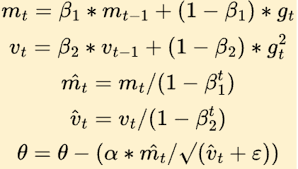

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

train_data = DataLoader(mnist_train, batch_size=32, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.49MB/s]


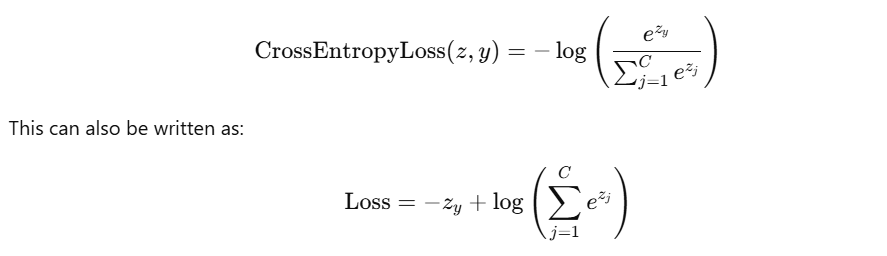



The term:

```math
-\log(\text{softmax}(z)[y])
```

is calculated **per sample** in the batch, and then:

### 🧮 For the batch:

The **CrossEntropyLoss** is **averaged (default)** or **summed** across the entire batch.

---

## 🔁 Full Process During Training (with Batch Size B)

Let:

* $z^{(i)}$ = logits for the $i^\text{th}$ sample in the batch
* $y^{(i)}$ = ground-truth class index for that sample

### 📌 Step-by-step:

1. For each sample $i \in [1, B]$, compute:

```math
L^{(i)} = -\log\left( \frac{e^{z^{(i)}_{y^{(i)}}}}{\sum_{j=1}^{C} e^{z^{(i)}_j}} \right)
```

2. Sum or average over all $i \in \{1, ..., B\}$:

#### a) **Default in PyTorch: `reduction="mean"`**

```math
\text{Total Loss} = \frac{1}{B} \sum_{i=1}^{B} L^{(i)}
```

#### b) **If you set: `reduction="sum"`**

```math
\text{Total Loss} = \sum_{i=1}^{B} L^{(i)}
```

3. 🔁 **Backpropagation** is performed on this **total loss**, and the gradients are accumulated for parameter updates.

---

### ✅ So Yes:

> The term `-log(softmax(z)[y])` is **computed for each sample** and then **aggregated over the batch** (mean or sum), and **that total loss is used for backprop and weight updates**.

---

## 🔍 Bonus Tip (PyTorch Code):

```python
criterion = nn.CrossEntropyLoss(reduction='mean')  # default
loss = criterion(logits, targets)
```

If you want **sum instead of mean**:

```python
criterion = nn.CrossEntropyLoss(reduction='sum')
```

Or per-sample loss (no aggregation):

```python
criterion = nn.CrossEntropyLoss(reduction='none')  # returns shape (B,)
```

---


In [ ]:
for epoch in range(3):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_data):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)

        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)

        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")



Epoch 1
  Batch   1: Loss = 2.3342, Accuracy = 15.62%
  Batch 101: Loss = 0.6509, Accuracy = 71.88%
  Batch 201: Loss = 0.4532, Accuracy = 81.25%
  Batch 301: Loss = 0.3390, Accuracy = 90.62%
  Batch 401: Loss = 0.7079, Accuracy = 87.50%
  Batch 501: Loss = 0.4201, Accuracy = 87.50%
  Batch 601: Loss = 0.1995, Accuracy = 90.62%
  Batch 701: Loss = 0.2322, Accuracy = 93.75%
  Batch 801: Loss = 0.2628, Accuracy = 96.88%
  Batch 901: Loss = 0.2258, Accuracy = 90.62%
  Batch 1001: Loss = 0.2623, Accuracy = 87.50%
  Batch 1101: Loss = 0.2616, Accuracy = 93.75%
  Batch 1201: Loss = 0.6025, Accuracy = 78.12%
  Batch 1301: Loss = 0.5669, Accuracy = 71.88%
  Batch 1401: Loss = 0.1973, Accuracy = 93.75%
  Batch 1501: Loss = 0.3754, Accuracy = 90.62%
  Batch 1601: Loss = 0.3833, Accuracy = 84.38%
  Batch 1701: Loss = 0.2883, Accuracy = 90.62%
  Batch 1801: Loss = 0.1193, Accuracy = 93.75%
==> Epoch 1 Summary: Total Loss = 822.6131, Accuracy = 86.01%

Epoch 2
  Batch   1: Loss = 0.2401, Accuracy 